## BIG DATA

## Actividad 4 | Metricas de calidad de resultados

## Esteban Guerrero Rivero A01795053

[1. Marco Teórico](#marco)

[2. Construcción de la Muestra Representativa (M)](#muestra)

[3. División de la Muestra en Entrenamiento y Prueba](#division)

[4. Selección de Métricas de Evaluación](#metricas)

[5. Entrenamiento de Modelos de Aprendizaje](#entrenamiento)

[6. Análisis Crítico de Resultados](#analisis)


<a id="marco"></a>
# 1. Marco teórico

Introducción.

La mayor parte de la información actual se ha generado solamente en los ultimos años, desde el punto de vista de la generación y evaluacion de moidelos en Big Data el enfoque tradicional de machine learning privilegia la presiciÓn, sin considerar el costo computacional o la eficiencia enegética.

Un ejemplo lo son los sectores donde se generan datos masivos, como lo son:

Clima y medio ambiente

*Sensores ambientales general petabytes de datos al año, es importante analizar la información en tiempo real*

Biologia y medicina

*El estudio del genoma humano, las imÁgenes medicas y expedientes electrónicos generan una gran cantidad de información, en este ambiente se requiere de gran presiciÓn sion comprometer la integridad ni la confidencialidad de los datos*

Astronomia

*Los telescopíos modernos generanm terabytes por noche, inclusive proyectos modernos en marcha como lo es el telescopio Vera Rubin producirán información en el orden de los petabytes, lo cual exigirá el empleo de modelos computacionales mas eifcientes.*

Por lo anterior se deben seguier las siguientes recomendaciones y buenas prácticas 

Los modelos complejos cono los SVM o Bayesianos no paramétricos son precisos, pero ineficientes para grandes volumenes de información, por lo que se sugiere convertir esos modelos a versiones semiparametricas para reducir el costo computacional

Favorecer el aprendizaje local, por lo que se debe dividir el modelo en clusters para creazr modelos locales más simples

Se debe evitar el uso de Deep Learning en big data, se recomienta utilixar tecnicas semiparametricas

En reumen, la tendencia a trabajar cada vez con mayores cantidades de datos hace que sea imprescindible evolucionar hacia enfoques más sostenibles de aprendizaje máquina, asi mismo un correcto modelado (selección, limpieza de datos, selección del modelo) es escencial para poder obtener los beneficios del apredizaje máquina en Big Data.

In [144]:
# Inicializar Spark
import findspark, os, re
findspark.init()
from pyspark.sql import SparkSession, functions as F

spark = SparkSession.builder \
    .master('local[*]') \
    .config('spark.driver.memory', '32g') \
    .config("spark.executor.memory", "32g") \
    .appName('AmazonBooks-Sampling') \
    .getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', 'true')

In [145]:
from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

<a id="seleccion"></a>
## Selección de los datos

In [146]:
reviews = spark.read.csv("Books_rating.csv",
                    header=True,
                    inferSchema=True,
                    sep=",",
                    quote='"',        # <- Maneja correctamente los textos entre comillas
                    escape='"'        # <- (opcional) Escapa comillas internas si las hubiera
                    )
books = spark.read.csv("books_data.csv",
                    header=True,
                    inferSchema=True,
                    sep=",",
                    quote='"',        # <- Maneja correctamente los textos entre comillas
                    escape='"'        # <- (opcional) Escapa comillas internas si las hubiera
                    )
full_data = reviews.join(books, on='Title', how='left')

In [147]:
import pandas as pd
cols = [
    "review/score",
    "price",
    "publishedDate",
    "ratingsCount",
]

# 1) Usando describe() — devuelve count, mean, stddev, min, max
desc_df = full_data.select(cols).describe().toPandas()
desc_transposed = desc_df.set_index('summary').T.drop('count', axis=1)

print(desc_transposed)

summary                      mean              stddev        min     max
review/score    4.215289333333334  1.2030537472334022        1.0     5.0
price          21.762655874939163  26.206540521370115        1.0   995.0
publishedDate  1985.0539203308863  38.030385731963555  101-01-01    20??
ratingsCount   272.09905936069714   788.8162145564311        1.0  4895.0


In [148]:
cols = [
    "publishedDate",
    "ratingsCount",
]

full_data = full_data \
    .withColumn('desc_len_chars', F.length(F.col('description'))) \
    .withColumn('desc_len_tokens', F.size(F.split(F.col('description'), r'\s+')))

stats_desc = full_data.agg(
    F.count('description').alias('count'),
    F.min('desc_len_chars').alias('min_chars'),
    F.max('desc_len_chars').alias('max_chars'),
    F.mean('desc_len_chars').alias('mean_chars'),
    F.stddev('desc_len_chars').alias('stddev_chars'),
    F.mean('desc_len_tokens').alias('mean_tokens'),
    F.stddev('desc_len_tokens').alias('stddev_tokens')
)
stats_desc.show()

+-------+---------+---------+----------------+----------------+-----------------+------------------+
|  count|min_chars|max_chars|      mean_chars|    stddev_chars|      mean_tokens|     stddev_tokens|
+-------+---------+---------+----------------+----------------+-----------------+------------------+
|2359775|        1|    26092|722.179402697291|630.200551802687|91.85404533333333|103.08612464092816|
+-------+---------+---------+----------------+----------------+-----------------+------------------+



<a id="muestra"></a>
# 2. Construcción de la Muestra Representativa (M)

Las particiones se crean a partir del producto cruzado entre:
- **review_score_group**: Low (1–2), Mid (3), High (4–5)
- **categories_group**: Fiction / Non-Fiction

### Probabilidades empíricas por combinación:

In [149]:
from pyspark.sql.functions import col, when, regexp_replace, split, explode

# 1) Definir R_group
full_data = full_data.withColumn(
    "R_group",
    when(col("review/score") <= 2, "Low")
    .when(col("review/score") == 3, "Mid")
    .otherwise("High")
)

# 2) Definir C_group limpiando y usando la primera etiqueta
#    (asume formato ["Cat1","Cat2",…])
full_data = full_data.withColumn(
    "first_cat",
    split(regexp_replace(col("categories"), r"^\[|\]$", ""), r",\s*")[0]
)
full_data = full_data.withColumn(
    "C_group",
    when(col("first_cat").contains("fiction"), "Fiction").otherwise("Non‑Fiction")
).drop("first_cat")

# 3) Ver probabilidades empíricas de cada combinación
freqs = (
    full_data
    .groupBy("R_group", "C_group")
    .count()
    .withColumnRenamed("count", "N")
    .withColumn("Pr", (col("N") / full_data.count()).cast("double"))
    .orderBy("R_group", "C_group")
)
freqs.show(truncate=False)


+-------+-----------+-------+---------------------+
|R_group|C_group    |N      |Pr                   |
+-------+-----------+-------+---------------------+
|High   |Fiction    |38670  |0.01289              |
|High   |Non‑Fiction|2354289|0.784763             |
|Low    |Fiction    |3736   |0.0012453333333333333|
|Low    |Non‑Fiction|349010 |0.11633666666666667  |
|Mid    |Fiction    |3103   |0.0010343333333333333|
|Mid    |Non‑Fiction|251192 |0.08373066666666666  |
+-------+-----------+-------+---------------------+



In [150]:
from pyspark.sql.functions import col

# 1) Función auxiliar
def get_partition(df, r_group: str, c_group: str):
    return df.filter((col("R_group") == r_group) & (col("C_group") == c_group))

# 2) Generar un dict con todos los estratos
partitions = {}
for rg in ["Low", "Mid", "High"]:
    for cg in ["Fiction", "Non‑Fiction"]:
        key = f"{rg}×{cg}"
        partitions[key] = get_partition(full_data, rg, cg)

# 3) Ver conteos de cada partición
for key, df_part in partitions.items():
    print(f"{key}: {df_part.count():,} rows")

Low×Fiction: 3,736 rows
Low×Non‑Fiction: 349,010 rows
Mid×Fiction: 3,103 rows
Mid×Non‑Fiction: 251,192 rows
High×Fiction: 38,670 rows
High×Non‑Fiction: 2,354,289 rows


## Técnica de muestreo
Se usará **muestreo aleatorio simple estratificado** (SRS) dentro de cada estrato (R_group x C_group) por estas razones:.

**Control de heterogeneidad**: cada combinación de sentimiento (Low/Mid/High) y género (Fiction/Non‑Fiction) se trata como una subpoblación homogénea.

**Minimización de sesgos**: al muestrear por estrato, evitamos que los grupos grandes dominen la muestra.

**Asignación tipo Neyman**: definimos fracciones mayores en estratos pequeños para garantizar un tamaño de muestra mínimo, y menores en estratos muy grandes para eficiencia.

### Fórmula de tamaño de muestra de Cochran

$$
n_0 = \frac{Z^2 \cdot p \cdot (1 - p)}{E^2}
$$

Donde:

- **n₀** = tamaño de muestra inicial para poblaciones grandes (antes de cualquier ajuste para poblaciones finitas)  
- **Z** = valor z (por ejemplo, 1.96 para un 95 % de confianza)  
- **p** = proporción poblacional estimada (usar 0.5 si se desconoce)  
- **E** = margen de error  

In [151]:
#Definición del tamaño de muestra
import math

Z = 2.56 # 99% de confianza
p = 0.5 # probabilidad de que el usuario le guste el libro
E = 0.01 # margen de error

n0 = (Z**2 * p * (1-p)) / (E**2)
print("Tamaño de muestra necesario:", n0)

N = full_data.count() # población total

n = n0 / (1 + ((n0 - 1) / N))
n = math.ceil(n)
print(f"Tamaño de muestra ajustado (población finita): {n}")

Tamaño de muestra necesario: 16384.0
Tamaño de muestra ajustado (población finita): 16296


### Fórmula para muestreo estratificado

El muestreo estratificado se utiliza cuando una población puede dividirse en subgrupos distintos, o estratos, como grupos de edad, género o nivel educativo. El tamaño de muestra para cada estrato puede determinarse mediante el uso de la asignación proporcional:

$$
n_h = \frac{N_h}{N} \cdot n
$$

Donde:

- **nₕ** = tamaño de muestra para el estrato h  
- **Nₕ** = tamaño de la población en el estrato h  
- **N** = tamaño total de la población  
- **n** = tamaño total de la muestra  

In [152]:
from pyspark.sql.functions import concat_ws, col
fraction = n / N


# 1) Definición de frecuencias para obtener como mínimo 50 muestras por estrato
fractions = {
    "Low×Fiction":      50/3756,
    "Low×Non‑Fiction":  fraction,
    "Mid×Fiction":      50/3103,
    "Mid×Non‑Fiction":  fraction,
    "High×Fiction":     fraction,
    "High×Non‑Fiction": fraction,
}

# 2) Creo la columna compuesta
full2 = full_data.withColumn(
    "stratum",
    concat_ws("×", col("R_group"), col("C_group"))
)

# 3) Muestreo estratificado usando esa columna
sample_df = full2.stat.sampleBy("stratum", fractions, seed=42)

# 4) Veo el conteo por estrato para validar
sample_df.groupBy("R_group", "C_group") \
         .count() \
         .orderBy("R_group", "C_group") \
         .show(truncate=False)


+-------+-----------+-----+
|R_group|C_group    |count|
+-------+-----------+-----+
|High   |Fiction    |225  |
|High   |Non‑Fiction|12936|
|Low    |Fiction    |58   |
|Low    |Non‑Fiction|1861 |
|Mid    |Fiction    |56   |
|Mid    |Non‑Fiction|1414 |
+-------+-----------+-----+



In [153]:
# Estadísticas exploratorias por grupo
sample_df.groupBy('R_group', 'C_group') \
    .agg(F.count('*').alias('N'),
         F.round(F.avg('review/score'),2).alias('MeanScore')) \
    .orderBy('R_group','C_group') \
    .show()

+-------+-----------+-----+---------+
|R_group|    C_group|    N|MeanScore|
+-------+-----------+-----+---------+
|   High|    Fiction|  225|      4.8|
|   High|Non‑Fiction|12936|     4.75|
|    Low|    Fiction|   58|      1.6|
|    Low|Non‑Fiction| 1861|     1.43|
|    Mid|    Fiction|   56|      3.0|
|    Mid|Non‑Fiction| 1414|      3.0|
+-------+-----------+-----+---------+



In [154]:
# 3) Verificación de probabilidades de cada combinación en la muestra
#    (deberían ser similares a las de la población)
#    (asume que la muestra es representativa)
freqs_Sample = (
    sample_df
    .groupBy("R_group", "C_group")
    .count()
    .withColumnRenamed("count", "N")
    .withColumn("Pr", (col("N") / sample_df.count()).cast("double"))
    .orderBy("R_group", "C_group")
)
freqs_Sample.show(truncate=False)

+-------+-----------+-----+---------------------+
|R_group|C_group    |N    |Pr                   |
+-------+-----------+-----+---------------------+
|High   |Fiction    |225  |0.013595166163141994 |
|High   |Non‑Fiction|12936|0.7816314199395771   |
|Low    |Fiction    |58   |0.0035045317220543807|
|Low    |Non‑Fiction|1861 |0.11244712990936556  |
|Mid    |Fiction    |56   |0.0033836858006042296|
|Mid    |Non‑Fiction|1414 |0.0854380664652568   |
+-------+-----------+-----+---------------------+



In [155]:
print("Número de registros: " + str(sample_df.count()))
print("Número de columnas: " + str(len(sample_df.columns)))

Número de registros: 16550
Número de columnas: 24


<a id="division"></a>
# 3. División de la Muestra en Entrenamiento y Prueba

In [156]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import NumericType

# 1. Seleccionar columnas numéricas reales
features_cols = ["review/score", "Price", "ratingsCount", "desc_len_chars", "desc_len_tokens"]

# 2. Asegurarse de que no hay valores nulos
sample_df = sample_df.select(*features_cols, "R_group", "C_group", "stratum").dropna()

# 3. Armar el vector de características
assembler = VectorAssembler(inputCols=features_cols, outputCol="features")
sample_df = assembler.transform(sample_df)

# 4. Verifica que se creó la columna 'features'
sample_df.select("features").show(5, truncate=False)

+----------------------------+
|features                    |
+----------------------------+
|[4.0,6.52,39.0,228.0,32.0]  |
|[4.0,6.52,39.0,228.0,32.0]  |
|[5.0,6.48,52.0,1078.0,189.0]|
|[4.0,10.99,1.0,429.0,83.0]  |
|[5.0,10.95,2.0,185.0,30.0]  |
+----------------------------+
only showing top 5 rows



<a id="conjuntos"></a>
## Preparación del conjunto de entrenamiento y prueba

In [157]:
# Dividir el dataset en entrenamiento y prueba
train_df, test_df = sample_df.randomSplit([0.7, 0.3], seed=42)
print(f"Entrenamiento: {train_df.count()} filas")
print(f"Prueba: {test_df.count()} filas")

Entrenamiento: 828 filas
Prueba: 398 filas


<a id="metricas"></a>
# 4. Selección de Métricas de Evaluación

Evaluación de Modelos de Clasificación

El objetivo del codigo será implementar un pipeline de ML en PySpark para predecir la variable "review/score" a partir de varias características numéricas

El modelo a emplear es un random forest clasifier, este modelo crea multiples arboles de desición y conbina sus resultados, se emplea este modelo debido a que es robusto, y preciso, especialmente con variables no lineales.

## 1. Accuracy (Precisión)

Es la proporción de predicciones correctas sobre el total de predicciones:

### Ventajas:

- Es fácil de interpretar.
- Útil cuando las clases están balanceadas.

### Limitaciones:

- No es robusta ante desbalanceo de clases.  
  Por ejemplo, si el 80% de los datos son “5 estrellas”, un modelo que siempre predice 5 tendrá alta accuracy pero no será útil.

## 2. Precision, Recall y F1-Score (por clase)

Estas métricas se calculan para cada clase (por ejemplo, “1 estrella”, “2 estrellas”, etc.) y son especialmente útiles cuando algunas clases son mucho menos frecuentes que otras.

### Precision         

La precisión mide qué proporción de las instancias que el modelo predijo como positivas (o como una clase específica) realmente lo eran.

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

Alta precisión significa pocos falsos positivos.
Es útil cuando el costo de un falso positivo es alto.

_Ejemplo: en un sistema de detección de spam, no quieres marcar correos legítimos como spam._

### Recall             

El recall mide qué proporción de las instancias reales positivas (o de una clase) fueron correctamente detectadas por el modelo.

$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

Alto recall significa pocos falsos negativos.
Es útil cuando es crítico no perder ninguna instancia positiva.

_Ejemplo: en detección de enfermedades, es importante detectar todos los casos positivos, incluso si hay algunos falsos positivos._

### F1-Score           

El F1-score es la media armónica entre precision y recall. Es una métrica que balancea ambas cuando hay una compensación entre falsos positivos y falsos negativos.


$$
\text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Es útil cuando quieres encontrar un equilibrio entre precision y recall.
Toma un valor entre 0 y 1 (1 es lo mejor).


### Ventajas:

Informan sobre el desempeño por clase.
El F1-score es útil si hay desequilibrio en clases (como entre puntuaciones 1–5).

##  3. Matriz de confusión

Es fundamental para problemas multiclase.  
Muestra cuántas veces el modelo predijo correctamente por clase.

Útil para detectar patrones de error comunes (por ejemplo, si el modelo confunde 4 y 5 estrellas, pero distingue bien 1 y 5).


## Métricas a emplear

Dado que estás clasificando scores de 1 a 5 estrellas (posiblemente reagrupadas), te recomiendo usar:

Objetivo                        Métricas recomendadas                 
Evaluación general del modelo    _accuracy_                           
Evaluación detallada por clase   _precision, recall, f1-score_
Análisis de errores               _matriz de confusión_

<a id="entrenamiento"></a>
# 5. Entrenamiento de Modelos de Aprendizaje

In [158]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# 1. Convertir la etiqueta (review/score) en una variable categórica
indexer = StringIndexer(inputCol="review/score", outputCol="label")
train_df = indexer.fit(train_df).transform(train_df)
test_df = indexer.fit(test_df).transform(test_df)

# 2. Definir el modelo
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=20)

# 3. Entrenar el modelo
model = rf.fit(train_df)

# 4. Realizar predicciones
predictions = model.transform(test_df)

# 5. Evaluar
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy del modelo: {accuracy:.4f}")

# 6. Mostrar predicciones de ejemplo
predictions.select("review/score", "label", "prediction", "features").show(5, truncate=False)

Accuracy del modelo: 0.8015
+------------+-----+----------+----------------------------+
|review/score|label|prediction|features                    |
+------------+-----+----------+----------------------------+
|1.0         |2.0  |3.0       |[1.0,10.78,19.0,738.0,119.0]|
|3.0         |3.0  |2.0       |[3.0,7.5,49.0,1235.0,220.0] |
|3.0         |3.0  |2.0       |[3.0,10.98,7.0,1206.0,200.0]|
|3.0         |3.0  |2.0       |[3.0,11.21,9.0,191.0,35.0]  |
|4.0         |1.0  |1.0       |[4.0,10.99,1.0,429.0,83.0]  |
+------------+-----+----------+----------------------------+
only showing top 5 rows



In [163]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_pr  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_rc  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
print("Accuracy :", evaluator_acc.evaluate(predictions))
print("F1-Score :", evaluator_f1.evaluate(predictions))
print("Precision (promedio):", evaluator_pr.evaluate(predictions))
print("Recall (promedio):", evaluator_rc.evaluate(predictions))

Accuracy : 0.8015075376884422
F1-Score : 0.8015075376884423
Precision (promedio): 0.8015075376884423
Recall (promedio): 0.8015075376884423


In [160]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans(featuresCol="features", k=3, seed=42)
kmeans_model = kmeans.fit(sample_df)
clusters = kmeans_model.transform(sample_df)

evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette")
silhouette = evaluator.evaluate(clusters)

print(f"Resultados del modelo no supervisado (KMeans):")
print(f"Silhouette Score: {silhouette:.4f}")
print("Centroides:")
for i, center in enumerate(kmeans_model.clusterCenters()):
    print(f"  Centro {i}: {center}")

Resultados del modelo no supervisado (KMeans):
Silhouette Score: 0.5976
Centroides:
  Centro 0: [   4.16801619   18.80989879   60.97975709 1079.17408907  175.64574899]
  Centro 1: [  4.13884298  18.30034711 115.77355372 279.49256198  45.06942149]
  Centro 2: [   3.88188976   22.71598425   16.49606299 2261.95275591  370.92913386]


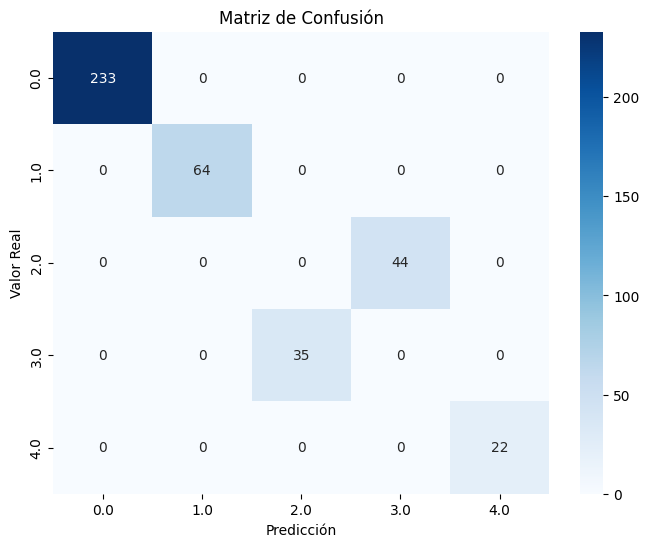

C:\Users\esteb\AppData\Local\Temp\ipykernel_41040\53762958.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=pred_df, ax=ax[0], palette='pastel')
C:\Users\esteb\AppData\Local\Temp\ipykernel_41040\53762958.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='prediction', data=pred_df, ax=ax[1], palette='muted')


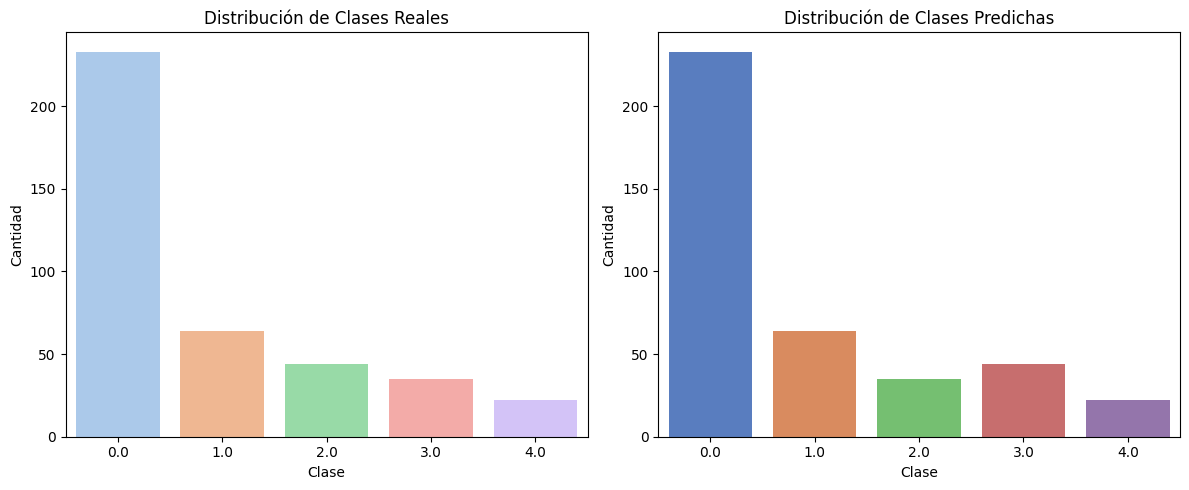

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Solo las columnas necesarias para visualización
pred_df = predictions.select("label", "prediction").toPandas()

# Crear matriz de confusión
conf_matrix = pd.crosstab(pred_df['label'], pred_df['prediction'], rownames=['Actual'], colnames=['Predicted'])

# Visualizar matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Conteo de clases reales
sns.countplot(x='label', data=pred_df, ax=ax[0], palette='pastel')
ax[0].set_title("Distribución de Clases Reales")
ax[0].set_xlabel("Clase")
ax[0].set_ylabel("Cantidad")

# Conteo de clases predichas
sns.countplot(x='prediction', data=pred_df, ax=ax[1], palette='muted')
ax[1].set_title("Distribución de Clases Predichas")
ax[1].set_xlabel("Clase")
ax[1].set_ylabel("Cantidad")

plt.tight_layout()
plt.show()

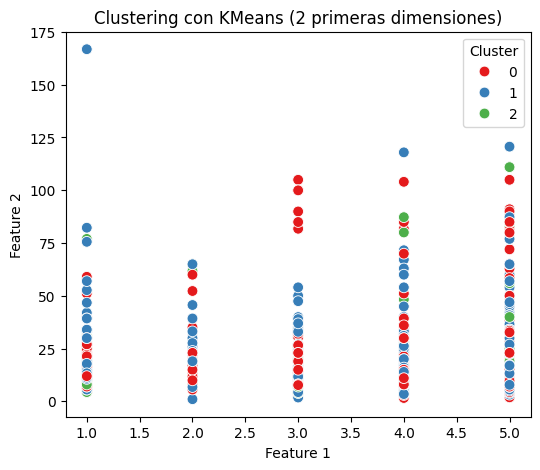

In [162]:
# Visualización del resultado de clustering (usando 2 primeras dimensiones del vector)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pandas_clusters = clusters.select("prediction", "features").toPandas()
pandas_clusters["x"] = pandas_clusters["features"].apply(lambda v: v[0])
pandas_clusters["y"] = pandas_clusters["features"].apply(lambda v: v[1])

plt.figure(figsize=(6, 5))
sns.scatterplot(data=pandas_clusters, x="x", y="y", hue="prediction", palette="Set1", s=60)
plt.title("Clustering con KMeans (2 primeras dimensiones)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title="Cluster")
plt.show()

<a id="analisis"></a>
# 6. Análisis de Resultados

MODELO SUPERVISADO

Las métricas de presición y f1-score, al ser superiores a 80% son bastante aceptables, esto indicca que el 80.15% de las predicciones fueron correctas, tembien indican que el modelo tiene un buen balance entre presicion y cobertura.

Las métricas  de presicion y recall indican que el modelo detecta una buena proporcion de los verdaderos casos positivos, sin embargo, son muy parecidos todas las métricas, por lo que se puede deber a 2 factores

la distribucion de clases es balanceada, por lo que el modelo predice cada clase de forma similar, lo que hace que la presicion sea similar al recall, y por enfe el f1-score y accuracy tenderian a coincidir.

Tambien podria ser un tema de redondeo de PySpark o tambien podria tratarse de un error en el código.

MODELO NO SUPERVISADO

Con la métrica de Silhouette con un valor de 0.5976 y 3 grupos de centroides con diferencias notables, este modelo esta separando los clusters adecuadamente, y estos presentan una buena cohesion, la difefencia en los centroides muestra que el modelo identifica patrones utiles.

Aunque en esta parte del ejercicio nos centrramos en las metricas de evaluación, seria importante considerar el costo computacional del procedimiento, desconozco al momento si existe manera por parte de PySpark de cuantificar el costo  computacional o de recursos de las actividades realizadas.

También las métricas muestran la importancia de realizar un correcto particionamiento de la población, tomando en cuenta los tipos de datos que lo conforman, el tipo de información asi como identificar clases embedidads en la estructura de los archivos.

